[Home](index.ipynb) > [Notebooks](notebooks.ipynb) > Copenhagen Network Study

<img style='float: left;' src='https://www.gesis.org/typo3conf/ext/gesis_web_ext/Resources/Public/webpack/dist/img/logo_gesis_en.svg' width='150'>

### ``compsoc`` – Computational Social Methods in Python

# Copenhagen Networks Study: Multiplex interactions among 845 university students

**Author**: [Haiko Lietz](https://www.gesis.org/person/haiko.lietz)

**Affiliation**: [GESIS - Leibniz Institute for the Social Sciences](https://www.gesis.org/), Cologne, Germany

**Publication date**: XX.XX.XXXX (version 1.0)

***

## Introduction

The Copenhagen Networks Study is a beacon in demonstrating the power of a mix of digital behavioral data and survey data as well as mixed methods. In 2013, researchers handed out 1,000 cell phones to students at the Technical University of Denmark and recorded their physical location (via the cell phone’s GPS sensor), who was proximate to whom (via the Bluetooth sensor), who called whom, and who texted whom. In addition, their transactions on Facebook were collected, and their demographic and psychological traits were surveyed. Parts of this data are described by Sapiezynski et al. ([2019](https://doi.org/10.1038/s41597-019-0325-x)). They are made [freely available](https://doi.org/10.6084/m9.figshare.7267433) under an MIT License at figshare. Four types social relations are depicted in Figure 1.

|<img src='images/copenhagen.png' style='float: none; width: 480px'>|
|:--|
|<em style='float: center'>**Figure 1**: Social relations from the Copenhagen Networks Study</em>|

**In this notebook**, we develop a function that loads and normalizes all data of the Copenhagen Networks Study. Normalizing variables and unifying names makes it compatible with the `compsoc` tools.

## Dependencies and settings

In [1]:
import compsoc as cs
import itertools
import numpy as np
import os
import pandas as pd

In [2]:
path = 'data/copenhagen/'

## Copenhagen Networks Study interaction data
The dataset contains four types of tie and a user attribute.

First type of tie: **Network of physical proximity** among the participants (estimated via Bluetooth signal strength).

In [3]:
bluetooth = pd.read_csv(os.path.join(path, 'bt_symmetric.csv'))

In [4]:
print(bluetooth.columns)

Index(['# timestamp', 'user_a', 'user_b', 'rssi'], dtype='object')


In [5]:
print(open(os.path.join(path, 'bt_symmetric.README'), 'r').read())

column names:
	- timestamp
	- user A 
	- user B 
	- received signal strength

Notes:
Empty scans are marked with user B = -1 and RSSI = 0
Scans of devices outside of the experiment are marked with user B = -2. All non-experiment devices are given the same ID.



Second type of tie: **Network of phone calls** (start time, duration, no content).

In [6]:
calls = pd.read_csv(os.path.join(path, 'calls.csv'))

In [7]:
print(calls.columns)

Index(['timestamp', 'caller', 'callee', 'duration'], dtype='object')


In [8]:
print(open(os.path.join(path, 'calls.README'), 'r').read())

column names:
	- timestamp
	- calling user
	- call recipient
	- duration (-1 means a missed call)




Third type of tie: **Network of text messages** (time of message, no content).

In [9]:
sms = pd.read_csv(os.path.join(path, 'sms.csv'))

In [10]:
print(sms.columns)

Index(['timestamp', 'sender', 'recipient'], dtype='object')


In [11]:
print(open(os.path.join(path, 'sms.README'), 'r').read())

column names:
	- timestamp
	- sender
	- recipient



Fourth type of tie: **network of Facebook friendships**.

In [12]:
fb_friends = pd.read_csv(os.path.join(path, 'fb_friends.csv'))

In [13]:
print(fb_friends.columns)

Index(['# user_a', 'user_b'], dtype='object')


In [14]:
print(open(os.path.join(path, 'fb_friends.README'), 'r').read())

column names:
	- user A
	- user B

Edge lists of all declared facebook friendships which were formed before the end of the observation and not dissolved until after the end of the observation.



User attribute:

In [15]:
attributes = pd.read_csv(os.path.join(path, 'genders.csv'))

In [16]:
print(attributes.columns)

Index(['# user', 'female'], dtype='object')


## Normalization
The goal of normalization is to bring this data into a standard form which is needed for methods to be applicable.
### ``users`` dataframe
The ``genders`` dataframe is not a complete list of users as some users that participated in relational data collection did not answer the gender question or did not participate in the survey. We must construct a ``users`` dataframe by finding the set of unique users, ...

In [17]:
users = set(itertools.chain(*[
    bluetooth['user_a'].to_list(), 
    bluetooth['user_b'].to_list(), 
    calls['caller'].to_list(), 
    calls['callee'].to_list(), 
    sms['sender'].to_list(), 
    sms['recipient'].to_list(), 
    fb_friends['# user_a'].to_list(), 
    fb_friends['user_b'].to_list(), 
    attributes['# user'].to_list()
]))

In [18]:
users = pd.DataFrame(list(users), columns=['user'])
users = users[users['user'] >= 0] # remove artifact users from bluetooth dataframe

... merging user ``attributes`` into it, ...

In [19]:
users = pd.merge(left=users, right=attributes, left_on='user', right_on='# user', how='left')

... coding missing gender as 2, ...

In [20]:
users.fillna(2, inplace=True)

... and cleaning up:

In [21]:
users.rename(columns={'female': 'gender_id'}, inplace=True)
users['gender_id'] = users['gender_id'].astype(int)
users.drop(['# user'], axis=1, inplace=True)
users['user_id'] = users.index
users = users[['user_id', 'user', 'gender_id']]

In [22]:
users.tail()

,user_id,user,gender_id
840,840,845,0
841,841,846,0
842,842,847,1
843,843,848,2
844,844,850,2


The observation that the largest normalized user identifier (``user_id``) is six numbers shorter than the unnormalized identifier (``user``) means that we avoid dragging along six users for which we do not have any data at all. Since we have created a ``gender_id``, we must also create a dataframe with descriptions of these identifiers:

In [23]:
genders = pd.DataFrame([[0, 'male'], [1, 'female'], [2, 'unknown']], columns=['gender_id', 'gender'])

In [24]:
genders

,gender_id,gender
0,0,male
1,1,female
2,2,unknown


### Relations dataframes
#### Bluetooth
The network of physical proximity is an undirected network. The `# timestamp` column is a counter of seconds over four weeks, quantized into bins of five minutes. Within each time bin, all instances of users A and B discovering each other were identified, and the larger signal strength (`rssi`) is reported ([Sapiezynski et al., 2019](https://doi.org/10.1038/s41597-019-0325-x)):

In [25]:
bluetooth.head()

,# timestamp,user_a,user_b,rssi
0,0,0,-1,0
1,0,1,-1,0
2,0,2,-1,0
3,0,3,-2,-88
4,0,5,-1,0


These relations need cleaning. Remove ties where no other study participant is found in the bluetooth range ...

In [26]:
bluetooth = bluetooth[~bluetooth['user_b'].isin([-1, -2])]

... and remove ties with anomalous signal strengths:

In [27]:
bluetooth = bluetooth[bluetooth['rssi'] < 0]

The ``# timestamp`` column is a counter of seconds over four weeks. We add a column with a `datetime` type. The information on the year '1970' and the month '01' can be discarded but is necessary for filtering on days, hours, minutes, and seconds:

In [28]:
bluetooth['time'] = pd.to_datetime(bluetooth['# timestamp'], unit='s')

In addition, we divide the `# timestamp` by 300 to obtain 5 minute time bins:

In [29]:
bluetooth['time_bin'] = (bluetooth['# timestamp'] / 300).astype(int)

The `rssi` signal strength is measured in the logarithmic power unit of decibel-milliwatts. The larger the value, the closer two devices are:

<Axes: >

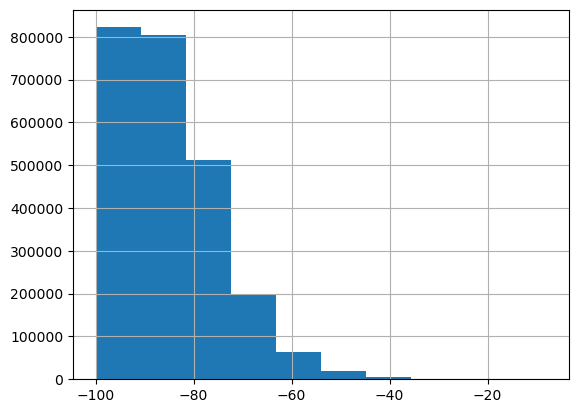

In [30]:
bluetooth['rssi'].hist()

It is desirable to transform signal strength into metric distance. The [formula](https://beingcoders.9mood.com/formula-to-convert-the-rssi-value-of-the-ble-bluetooth-low-energy-beacons-to-meters-12a2fa426a2e) is $distance = 10^{(p-rssi)/10^n}$ where $p$ is the expected power at a distance of 1 meter and $n$ is the broadcasting power. From Mones et al. ([2017](https://doi.org/10.1140/epjds/s13688-017-0103-y)) we can infer $p=-75$ and $n=2$. With these values we can compute the approximate distance of two devices:

In [31]:
bluetooth.loc[:, 'distance'] = round(10**((-75 - bluetooth['rssi']) / 10**2), 2)

After these transformations, the average distance and standard deviation are:

<Axes: >

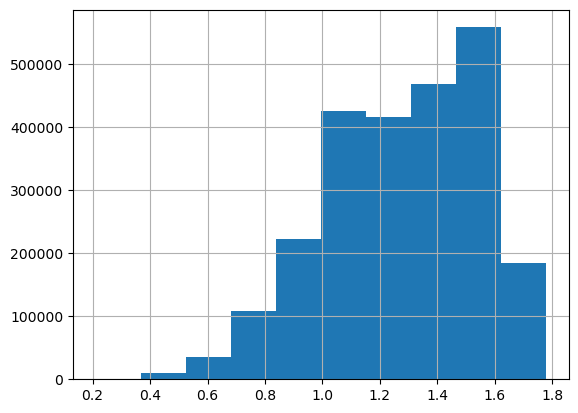

In [32]:
bluetooth['distance'].hist()

In [33]:
print('mean:', bluetooth['distance'].mean())
print('std:', bluetooth['distance'].std())

mean: 1.2808650462128153
std: 0.27000182233379405


The edge list still uses the unnormalized node identifiers. To replace them with the normalized ones, we need this dictionary which maps the unnormalized to normalized identifiers:

In [34]:
map = users.set_index('user').to_dict()['user_id']

Use the dictionary for mapping:

In [35]:
bluetooth['user_id_from'] = bluetooth['user_a'].map(map)
bluetooth['user_id_to'] = bluetooth['user_b'].map(map)

Now clean up:

In [36]:
bluetooth.sort_values(['time', 'user_id_from', 'user_id_to'], inplace=True)
bluetooth.reset_index(drop=True, inplace=True)
bluetooth = bluetooth[['user_id_from', 'user_id_to', 'rssi', 'distance', 'time', 'time_bin']]

In [37]:
bluetooth.head()

,user_id_from,user_id_to,rssi,distance,time,time_bin
0,21,20,-73,0.95,1970-01-01,0
1,47,19,-86,1.29,1970-01-01,0
2,49,48,-62,0.74,1970-01-01,0
3,69,44,-87,1.32,1970-01-01,0
4,90,64,-96,1.62,1970-01-01,0


The edge list for the network of physical proximity is now in the normalized form. The edges are defined in the first two columns, and the other columns can be used for slicing and filtering.

### Calls
The network of phone calls is directed and encodes who calls whom.

In [38]:
calls.head()

,timestamp,caller,callee,duration
0,184,300,301,121
1,3920,512,299,670
2,5623,301,300,504
3,9252,401,457,-1
4,15466,512,0,5


Process the timestamps, re-using the 5-min bins from physical proximity:

In [39]:
calls['time'] = pd.to_datetime(calls['timestamp'], unit='s')
calls['time_bin'] = (calls['timestamp'] / 300).astype(int)

Replace the user identifiers:

In [40]:
calls['user_id_from'] = calls['caller'].map(map)
calls['user_id_to'] = calls['callee'].map(map)

Missed calls are coded as -1. Since negative values cannot be used as edge weights, we recode -1 to 0. Missed calls are then indistinguishable from calls that lasted 0 seconds.

In [41]:
calls['duration'].replace(-1, 0, inplace=True)

Clean up:

In [42]:
calls.sort_values(['time', 'user_id_from', 'user_id_to'], inplace=True)
calls.reset_index(drop=True, inplace=True)
calls = calls[['user_id_from', 'user_id_to', 'duration', 'time', 'time_bin']]

In [43]:
calls.head()

,user_id_from,user_id_to,duration,time,time_bin
0,300,301,121,1970-01-01 00:03:04,0
1,512,299,670,1970-01-01 01:05:20,13
2,301,300,504,1970-01-01 01:33:43,18
3,401,457,0,1970-01-01 02:34:12,30
4,512,0,5,1970-01-01 04:17:46,51


### SMS
The network of text messages is directed and encodes who sends whom a short message.

In [44]:
sms.head()

,timestamp,sender,recipient
0,18,370,512
1,37,512,370
2,126,370,512
3,134,0,512
4,312,137,136


Process the timestamps:

In [45]:
sms['time'] = pd.to_datetime(sms['timestamp'], unit='s')
sms['time_bin'] = (sms['timestamp'] / 300).astype(int)

Replace the user identifiers:

In [46]:
sms['user_id_from'] = sms['sender'].map(map)
sms['user_id_to'] = sms['recipient'].map(map)

Clean up:

In [47]:
sms.sort_values(['time', 'user_id_from', 'user_id_to'], inplace=True)
sms.reset_index(drop=True, inplace=True)
sms = sms[['user_id_from', 'user_id_to', 'time', 'time_bin']]

In [48]:
sms.head()

,user_id_from,user_id_to,time,time_bin
0,370,512,1970-01-01 00:00:18,0
1,512,370,1970-01-01 00:00:37,0
2,370,512,1970-01-01 00:02:06,0
3,0,512,1970-01-01 00:02:14,0
4,137,136,1970-01-01 00:05:12,1


### Facebook friendships
The network of Facebook friendships encodes which two users are friends. Since one has to accept a friendship request at Facebook, the tie is undirected.

In [49]:
fb_friends.head()

,# user_a,user_b
0,0,512
1,0,263
2,0,525
3,0,285
4,0,543


In [50]:
fb_friends['user_id_from'] = fb_friends['# user_a'].map(map)
fb_friends['user_id_to'] = fb_friends['user_b'].map(map)

In [51]:
fb_friends.sort_values(['user_id_from', 'user_id_to'], inplace=True)
fb_friends.reset_index(drop=True, inplace=True)
fb_friends = fb_friends[['user_id_from', 'user_id_to']]

In [52]:
fb_friends.head()

,user_id_from,user_id_to
0,0,104
1,0,107
2,0,108
3,0,208
4,0,263


## Function
This function loads all data in one step:

In [53]:
def copenhagen_collection(
    path = 'data/copenhagen/'
):
    '''
    Description: Loads the normalized Copenhagen Networks Study data collection.
    
    Input:
        path: relative directory where the data is; set to 'data/copenhagen/' by default.
    
    Output: Six dataframes in this order: users, genders, bluetooth, calls, sms, fb_friends
    '''
    # load data
    import os
    import pandas as pd
    
    attributes = pd.read_csv(os.path.join(path, 'genders.csv'))
    bluetooth = pd.read_csv(os.path.join(path, 'bt_symmetric.csv'))
    calls = pd.read_csv(os.path.join(path, 'calls.csv'))
    sms = pd.read_csv(os.path.join(path, 'sms.csv'))
    fb_friends = pd.read_csv(os.path.join(path, 'fb_friends.csv'))
    
    # create users dataframe
    import itertools
    
    users = set(itertools.chain(*[
        bluetooth['user_a'].to_list(), 
        bluetooth['user_b'].to_list(), 
        calls['caller'].to_list(), 
        calls['callee'].to_list(), 
        sms['sender'].to_list(), 
        sms['recipient'].to_list(), 
        fb_friends['# user_a'].to_list(), 
        fb_friends['user_b'].to_list(), 
        attributes['# user'].to_list()
    ]))
    users = pd.DataFrame(list(users), columns=['user'])
    users = users[users['user'] >= 0]
    users = pd.merge(left=users, right=attributes, left_on='user', right_on='# user', how='left')
    users.fillna(2, inplace=True)
    users.rename(columns={'female': 'gender_id'}, inplace=True)
    users['gender_id'] = users['gender_id'].astype(int)
    users.drop(['# user'], axis=1, inplace=True)
    users['user_id'] = users.index
    users = users[['user_id', 'user', 'gender_id']]
    map = users.set_index('user').to_dict()['user_id']
    
    # create genders dataframe
    genders = pd.DataFrame([[0, 'male'], [1, 'female'], [2, 'unknown']], columns=['gender_id', 'gender'])
    
    # create bluetooth dataframe
    bluetooth = bluetooth[~bluetooth['user_b'].isin([-1, -2])]
    bluetooth = bluetooth[bluetooth['rssi'] < 0]
    bluetooth['time'] = pd.to_datetime(bluetooth['# timestamp'], unit='s')
    bluetooth['time_bin'] = (bluetooth['# timestamp'] / 300).astype(int)
    bluetooth.loc[:, 'distance'] = 10**((-75 - bluetooth['rssi']) / 10**2)
    bluetooth['user_id_from'] = bluetooth['user_a'].map(map)
    bluetooth['user_id_to'] = bluetooth['user_b'].map(map)
    bluetooth.sort_values(['time', 'user_id_from', 'user_id_to'], inplace=True)
    bluetooth.reset_index(drop=True, inplace=True)
    bluetooth = bluetooth[['user_id_from', 'user_id_to', 'rssi', 'distance', 'time', 'time_bin']]
    
    # create calls dataframe
    calls['time'] = pd.to_datetime(calls['timestamp'], unit='s')
    calls['time_bin'] = (calls['timestamp'] / 300).astype(int)
    calls['user_id_from'] = calls['caller'].map(map)
    calls['user_id_to'] = calls['callee'].map(map)
    calls['duration'].replace(-1, 0, inplace=True)
    calls.sort_values(['time', 'user_id_from', 'user_id_to'], inplace=True)
    calls.reset_index(drop=True, inplace=True)
    calls = calls[['user_id_from', 'user_id_to', 'duration', 'time', 'time_bin']]
    
    # create sms dataframe
    sms['time'] = pd.to_datetime(sms['timestamp'], unit='s')
    sms['time_bin'] = (sms['timestamp'] / 300).astype(int)
    sms['user_id_from'] = sms['sender'].map(map)
    sms['user_id_to'] = sms['recipient'].map(map)
    sms.sort_values(['time', 'user_id_from', 'user_id_to'], inplace=True)
    sms.reset_index(drop=True, inplace=True)
    sms = sms[['user_id_from', 'user_id_to', 'time', 'time_bin']]
    
    # create fb_friends dataframe
    fb_friends['user_id_from'] = fb_friends['# user_a'].map(map)
    fb_friends['user_id_to'] = fb_friends['user_b'].map(map)
    fb_friends.sort_values(['user_id_from', 'user_id_to'], inplace=True)
    fb_friends.reset_index(drop=True, inplace=True)
    
    return users, genders, bluetooth, calls, sms, fb_friends

## Using the function

Load the collection like this:

In [54]:
users, genders, bluetooth, calls, sms, fb_friends = cs.copenhagen_collection()

## References

Mones, E., Stopczynski, A., & Lehmann, S. (2017). Contact activity and dynamics of the social core. *EPJ Data Science*, 6, 6. https://doi.org/10.1140/epjds/s13688-017-0103-y

Sapiezynski, P., Stopczynski, A., Lassen, D. D., & Lehmann, S. (2019). Interaction data from the Copenhagen Networks Study. *Scientific Data*, 6(1), 315. https://doi.org/10.1038/s41597-019-0325-x

***

## About this notebook

**License**: CC BY 4.0. Distribute, remix, adapt, and build upon ``compsoc``, even commercially, as long as you credit us for the original creation.

**Suggested citation**: Lietz, H. (2025). Copenhagen Networks Study: Multiplex interactions among 845 university students. Version 1.0 (XX.XX.XXXX). *compsoc – Computational Social Methods in Python*. Cologne: GESIS – Leibniz Institute for the Social Sciences. https://github.com/gesiscss/compsoc